# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [2]:
!pip install -q tf-keras
!pip install -q sentence-transformers

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
import nltk
import re
import os
from PIL import Image
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

from sentence_transformers import SentenceTransformer

import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, GroupShuffleSplit

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, 
                        message=".*encoder_attention_mask.*is deprecated.*")

In [4]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

True

In [5]:
DATAFRAME_PATH = "datasets/"
TRAIN_IMAGE_PATH = "datasets/train_images/"
TEST_IMAGE_PATH = "datasets/test_images/"
BLOCK_WORDS_PATH = "block/"
EXPERT_WEIGHT = .7
TRAIN_SIZE = .8
SEED = 125

In [6]:
tf.random.set_seed(SEED)
np.random.seed(SEED)

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### 1.1. Загрузка данных.

In [9]:
# функция загрузки данных в датафрейм
def df_load(file_name, *arg, path=DATAFRAME_PATH, columns_name=None, index_col=None):
    if not os.path.exists(path + file_name):
        raise ValueError(f'Файл {file_name} не найден.')
    try:
        df = pd.read_csv(path + file_name, sep=arg[0], decimal=arg[1], index_col=index_col)
        print(f'Данные {file_name} успешно загружены')
    except Exception as err:
        raise ValueError(f'Ошибка загрузки данных из файла {file_name}: {err}')
    if columns_name is not None:
        df.columns = columns_name
    print(f'Размерность датафрейма: {df.shape}\n'
          'Общая информация о датафрейме:')
    print(df.info())
    return(df)

In [10]:
df_expert = df_load(
    'ExpertAnnotations.tsv',
    '\t',
    '.',
    columns_name=['image', 'query_id', '1', '2', '3']
)

Данные ExpertAnnotations.tsv успешно загружены
Размерность датафрейма: (5821, 5)
Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5821 non-null   object
 1   query_id  5821 non-null   object
 2   1         5821 non-null   int64 
 3   2         5821 non-null   int64 
 4   3         5821 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB
None


In [11]:
df_crowd = df_load(
    'CrowdAnnotations.tsv',
    '\t',
    '.',
    columns_name=['image', 'query_id', 'fraction_yes', 'count_yes', 'count_no']
)

Данные CrowdAnnotations.tsv успешно загружены
Размерность датафрейма: (47829, 5)
Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47829 entries, 0 to 47828
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47829 non-null  object 
 1   query_id      47829 non-null  object 
 2   fraction_yes  47829 non-null  float64
 3   count_yes     47829 non-null  int64  
 4   count_no      47829 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
None


In [12]:
df_train = df_load('train_dataset.csv', ',', '.')

Данные train_dataset.csv успешно загружены
Размерность датафрейма: (5822, 3)
Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None


In [13]:
df_test = df_load('test_queries.csv', '|', '.', index_col=[0])

Данные test_queries.csv успешно загружены
Размерность датафрейма: (500, 3)
Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB
None


In [14]:
df_test_img = df_load('test_images.csv', ',', '.')

Данные test_images.csv успешно загружены
Размерность датафрейма: (100, 1)
Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes
None


In [15]:
block_words = df_load('child_block.csv', ',', '.', path=BLOCK_WORDS_PATH)

Данные child_block.csv успешно загружены
Размерность датафрейма: (74, 1)
Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   blockwords  74 non-null     object
dtypes: object(1)
memory usage: 724.0+ bytes
None


### 1.2. Изучение данных.

In [17]:
df_expert.sample(5)

,image,query_id,1,2,3
1208,2343525685_3eba3b6686.jpg,1509786421_f03158adfc.jpg#2,1,1,2
3917,3365783912_e12c3510d8.jpg,771048251_602e5e8f45.jpg#2,1,1,1
991,2224450291_4c133fabe8.jpg,3320032226_63390d74a6.jpg#2,1,1,1
4342,3503623999_bbd5dcfb18.jpg,254295381_d98fa049f4.jpg#2,1,1,1
4467,3537400880_8f410d747d.jpg,3576259024_9c05b163aa.jpg#2,1,1,1


In [18]:
df_crowd.sample(5)

,image,query_id,fraction_yes,count_yes,count_no
31072,3334537556_a2cf4e9b9a.jpg,2813992915_f732cf8539.jpg#2,0.0,0,3
43216,452419961_6d42ab7000.jpg,2497420371_74788d7ba1.jpg#2,0.0,0,3
13268,2521770311_3086ca90de.jpg,3019842612_8501c1791e.jpg#2,0.0,0,3
39663,3635577874_48ebaac734.jpg,2472980433_210ec62874.jpg#2,0.0,0,3
23267,3044746136_8b89da5f40.jpg,470373679_98dceb19e7.jpg#2,0.0,0,3


In [19]:
df_train.sample(5)

,image,query_id,query_text
1654,2704934519_457dc38986.jpg,2196846255_2c1635359a.jpg#2,A wrinkled dog wading in shallow water .
2822,3473264983_67917a931f.jpg,3494394662_3edfd4a34c.jpg#2,A man with a red collar and gray beard looks a...
5521,3545652636_0746537307.jpg,3217620013_8b17873273.jpg#2,A man in a red uniform is playing backset ball...
2454,2999730677_0cfa1c146e.jpg,3263395801_5e4cee2b9e.jpg#2,A motocross bike is being ridden along a woodl...
3568,488590040_35a3e96c89.jpg,400851260_5911898657.jpg#2,A mist overshadows a man in winter gear and th...


In [20]:
df_test.sample(5)

,query_id,query_text,image
26,1468389504_c724bdcad0.jpg#1,Two girls on a jungle gym .,1468389504_c724bdcad0.jpg
440,440190907_bf8b7ba8ef.jpg#0,A group of people walk through a shopping mall .,440190907_bf8b7ba8ef.jpg
105,2431120202_b24fe2333a.jpg#0,A girl cross-country skis .,2431120202_b24fe2333a.jpg
9,1232148178_4f45cc3284.jpg#4,There is a little blond hair girl with a green...,1232148178_4f45cc3284.jpg
360,3482859574_3908de3427.jpg#0,A group of girls wearing costumes stand in a p...,3482859574_3908de3427.jpg


In [21]:
df_test_img.sample(5)

,image
81,3514297698_0512623955.jpg
73,2737233999_34d60dc5c3.jpg
89,2687672606_275169c35d.jpg
13,3438981089_2ef1a6353c.jpg
97,3091962081_194f2f3bd4.jpg


In [22]:
block_words.sample(5)

,blockwords
24,schooler
3,infant
7,adolescent
67,wards
43,youths


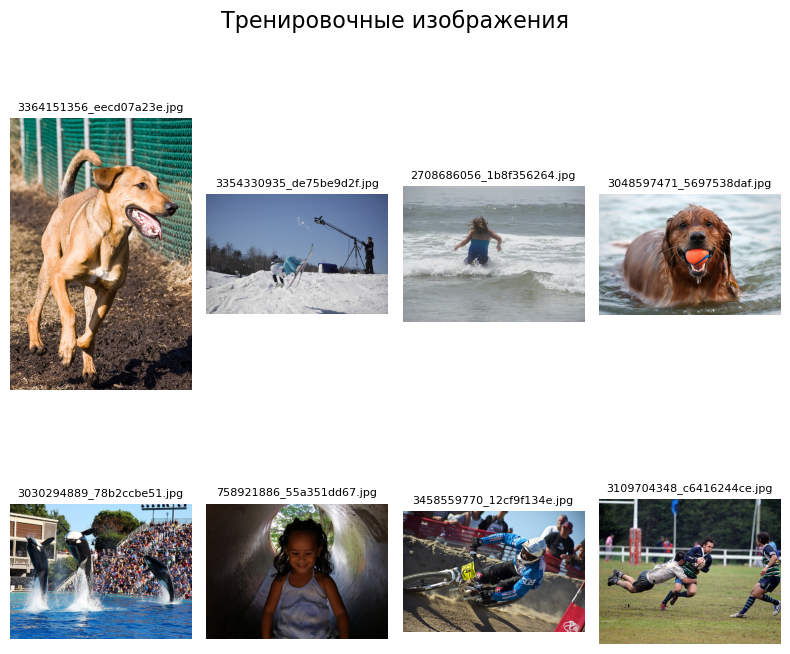

In [23]:
fig = plt.figure(figsize=(8,8))
fig.suptitle("Тренировочные изображения", fontsize=16)
for i, image_file in enumerate(df_train['image'].sample(8)):
    fig.add_subplot(2, 4, i+1)
    image = Image.open(os.path.join(TRAIN_IMAGE_PATH, image_file))
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_file), fontsize=8)
plt.tight_layout()
plt.show()

In [24]:
print(f'Уникальных фото в тренировчных данных - {len(df_train['image'].unique())}')

Уникальных фото в тренировчных данных - 1000


In [25]:
print(f'Уникальных комбинаций фото + описание с экспертной оценкой - {len(df_expert.groupby(['image', 'query_id']))}')

Уникальных комбинаций фото + описание с экспертной оценкой - 5821


In [26]:
print(f'Уникальных  комбинаций фото + описание с краудсорсинговой оценкой - {len(df_crowd.groupby(['image', 'query_id']))}')

Уникальных  комбинаций фото + описание с краудсорсинговой оценкой - 47829


### 1.3. Исследование оценок.

Посмотрим на распределение экспертных оценок. Количественно сколько разных оценок было проставлено каждым экспертом.

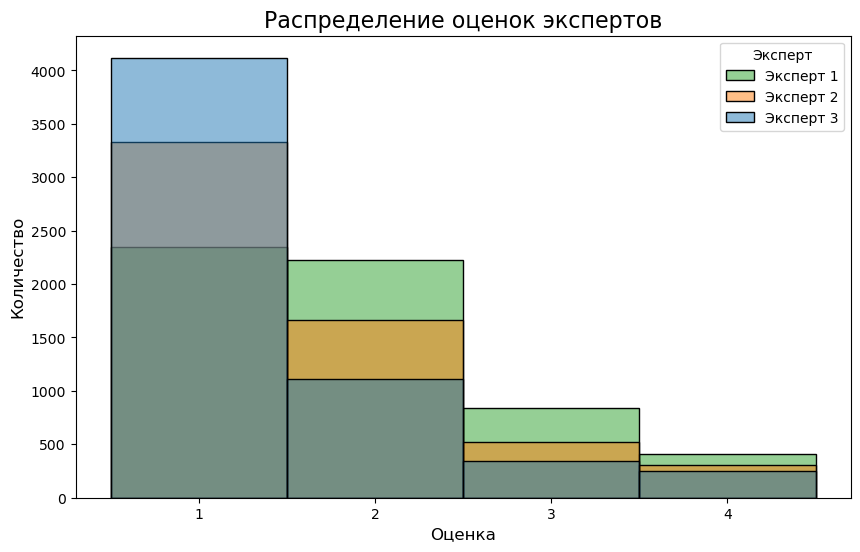

In [29]:
# Гистограммы с наложением
plt.figure(figsize=(10, 6))
sns.histplot(data=df_expert[['1','2','3']], bins=5, alpha=0.5, discrete=True)
plt.title('Распределение оценок экспертов', fontsize=16)
plt.xlabel('Оценка', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.legend(title='Эксперт', labels=['Эксперт 1', 'Эксперт 2', 'Эксперт 3'])
plt.xticks([1, 2, 3, 4])
# plt.grid(axis='y', alpha=0.5)
plt.show()

Как видим эксперты определили, что в большинстве случаев текст не соотвествует картинке.

Рассмотрим распределение оценок краудсорсинга. Для оценки соответствия будем использовать преобладающее количество голосов.

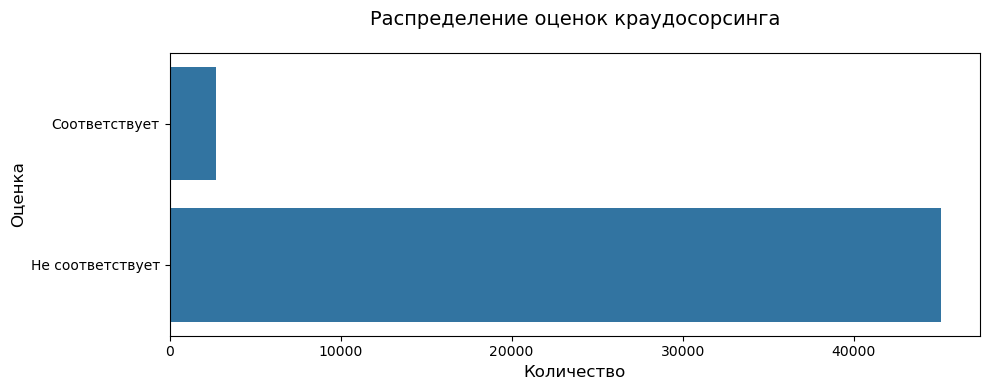

In [32]:
plt.figure(figsize=(10, 4))
ax = sns.countplot(
    data=df_crowd.apply(
        lambda x: "Соответствует" if x.count_yes > x.count_no else "Не соответствует",
        axis=1
    ),
    order=["Соответствует", "Не соответствует"]
)

ax.set_xlabel('Количество', fontsize=12)
ax.set_ylabel('Оценка', fontsize=12)
ax.set_title('Распределение оценок краудосорсинга', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

Оценки краудсорсинга также говорят, что большинтво описаний не соответсвует изображению.

Выведем обобщенную оценку соответсвия:
* Для экспертной оценки создадим среднуюю нормализованную оценку
* Для краудсорсинга так же сделаем нормализованную оценку, как отношение количества положительных оценок ко всем оценкам

In [35]:
df_expert['expert_norm'] = df_expert[['1', '2', '3']].mean(axis=1) / 4
# df_crowd['crowd_norm'] = df_crowd['count_yes'] / (df_crowd['count_yes'] + df_crowd['count_no'])
df_crowd['crowd_norm'] = np.where(
    (df_crowd['count_yes'] + df_crowd['count_no']) > 0,
    df_crowd['count_yes'] / (df_crowd['count_yes'] + df_crowd['count_no']),
    0.5
)

Теперь нужно объеденить датафреймы с оценками. Т.к. в датафреймах разное количество оцененных описаний, то объединять будем методом OUTER.

In [37]:
df_merged = pd.merge(
    df_expert[['image', 'query_id', 'expert_norm']],
    df_crowd[['image', 'query_id', 'crowd_norm']],
    how='outer',
    on=['image', 'query_id']
)

Оценим количество пропусков полученных в результате объединения.

In [39]:
nan_expert = df_merged['expert_norm'].isna().sum()
nan_crowd = df_merged['crowd_norm'].isna().sum()
print(f"Отсутствует экспертных оценок: {nan_expert}, crowd-оценок: {nan_crowd}")

Отсутствует экспертных оценок: 45501, crowd-оценок: 3493


Создадим обобщенную оценку соответсвия, как сумму оценок экспертов и краудсорсинга, с учетом веса оценки эксперта. В случае если какая-либо из оценок отвутсвует, в качестве обобщенной оценки берем оставшуюся без учета веса.

In [41]:
df_merged['final_score'] = np.where(
    df_merged['expert_norm'].isna(),
    df_merged['crowd_norm'],
    np.where(
        df_merged['crowd_norm'].isna(),
        df_merged['expert_norm'],
        df_merged['expert_norm'] * EXPERT_WEIGHT + df_merged['crowd_norm'] * (1 - EXPERT_WEIGHT)
    )
)

In [42]:
df_merged = df_merged[['image', 'query_id', 'final_score']].copy()

In [43]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51322 entries, 0 to 51321
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        51322 non-null  object 
 1   query_id     51322 non-null  object 
 2   final_score  51322 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


### Вывод по разделу:
* Загрузили данные с тренировочными, тестовыми запросами. А также данные с оценками от экспертов и краудсорсинга.
* Осмотрели загруженные данные, а так же выборочно помотрели изображения предоставленные для обучения.
* Сравнили распределение оценок от экспертов и краудсорсинга. Большинство оценок указывают на то, что описание не соотвествует изображению.
* Создали номализованные оценки соотвествия экспертов и краудсорсинга.
* Объеденили данные от разных оценщиков в один датафрейм.
* Вычислили обобщенную оценку соответствия на основе имеющихся оценок.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Создадим кастомный класс для очистки, токенизации и лемматизации текста (почти целиком скопировал из предыдущей работы по обработке тестов). 

#### Класс `TextPreprocessor`

Класс для предобработки текстовых данных.

#### Методы

#### `__init__(self, lang='english', block=None)`
**Инициализация текстового препроцессора**

Параметры:
- `lang` (str): Язык текста (по умолчанию 'english')
- `block` (list): Список слов для блокировки (заменяются на "BLOCK")

Инициализирует:
- Лемматизатор WordNetLemmatizer
- Список стоп-слов для указанного языка
- Блокируемые слова

---

#### `get_pos(self, tag)`
**Определение части речи для лемматизации**

Параметры:
- `tag` (str): POS-тег слова

Возвращает:
- Символьное обозначение части речи ('a', 'v', 'n', 'r')

Логика:
- J → прилагательное (a)
- V → глагол (v)
- N → существительное (n) 
- R → наречие (r)
- По умолчанию → существительное (n)

---

#### `preprocess_text(self, text)`
**Основной метод предобработки текста**

Параметры:
- `text` (str): Исходный текст для обработки

Возвращает:
- Обработанную текстовую строку

Логика обработки:
1. Для английского языка:
   - Удаляет все символы, кроме букв и пробелов
   - Приводит к нижнему регистру
2. Токенизирует текст
3. Удаляет стоп-слова
4. Если найдены слова из block-листа → заменяет весь текст на "BLOCK"
5. Лемматизирует слова с учетом части речи
6. Склеивает токены обратно в строку

---

#### `fit(self, X, y=None)`
**Фиктивный метод обучения (требуется для scikit-learn)**

Параметры:
- `X`: Входные данные
- `y`: Целевые значения (не используется)

Возвращает:
- self (объект препроцессора)

---

#### `transform(self, X)`
**Применение препроцессинга к данным**

Параметры:
- `X` (pd.Series/list): Коллекция текстов для обработки

Возвращает:
- pd.Series с обработанными текстами

Логика:
- Применяет `preprocess_text` к каждому элементу входных данных
- Сохраняет совместимость с scikit-learn Pipeline

In [48]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, lang='english', block=None):
        self.lemm = WordNetLemmatizer()
        self.lang = lang
        self.stopwords = nltk_stopwords.words(self.lang)
        self.block = block

    def get_pos(self, tag):
        if tag.startswith('J'):
            return 'a'
        elif tag.startswith('V'):
            return 'v'
        elif tag.startswith('N'):
            return 'n'
        elif tag.startswith('R'):
            return 'r'
        return 'n'
        
    def preprocess_text(self, text):
        if self.lang == 'english':
            text = re.sub(r"[^a-zA-Z\s]", "", text).lower()
        tokens = word_tokenize(text, language=self.lang)
        tokens = [word for word in tokens if word not in self.stopwords]
        if self.block and any(word in self.block for word in tokens):
            tokens = ["BLOCK"]
        pos_tags = pos_tag(tokens)
        final_tokens = []
        for token, tag in pos_tags:
            lemma = self.lemm.lemmatize(
                token,
                pos=self.get_pos(tag)
            )
            final_tokens.append(lemma)          
        return ' '.join(final_tokens)
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return X.apply(self.preprocess_text)

In [49]:
preprocessor = TextPreprocessor(block=block_words['blockwords'].values.flatten().tolist())
df_train['query_text_prep'] = preprocessor.transform(df_train['query_text'])

Визуализируем изображения которые мы хотим заблокировать для обучения.

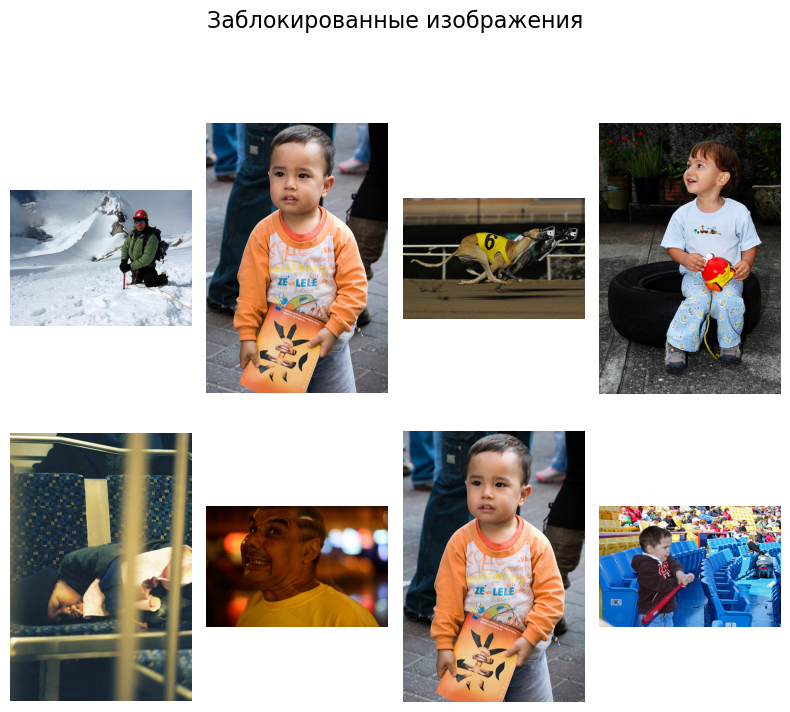

In [51]:
blocked_images = df_train[df_train['query_text_prep'] == "BLOCK"]

fig = plt.figure(figsize=(8, 8))
fig.suptitle("Заблокированные изображения", fontsize=16)
for i, image in enumerate(blocked_images['image'].sample(8)):
    fig.add_subplot(2, 4, i+1)
    image = Image.open(os.path.join(TRAIN_IMAGE_PATH, image))
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()

В заблокированые попали несколько фото детей. Так же присутсвуют собаки, видимо фильтруются по слову **boy**. Так же несколько фото не относящихся к детям. Но в таком вопросе лучше перебдеть, хотя ключевые слова возможно нуждаются в доработке.

Теперь объеденим датафреймы с тренировочными данными и оценками, изображения которые попали у нас в блок мы не берем.

In [54]:
df_train = pd.merge(
    df_train[df_train['query_text_prep'] != 'BLOCK'],
    df_merged,
    how='inner',
    on=['image', 'query_id']
)

In [55]:
df_train.sample(5)

,image,query_id,query_text,query_text_prep,final_score
3489,2815256108_fc1302117d.jpg,3006093003_c211737232.jpg#2,The man in glasses carrying an Obama poster is...,man glass carry obama poster talk cellphone,0.408333
2353,2757803246_8aa3499d26.jpg,136552115_6dc3e7231c.jpg#2,A mountain biker is jumping his bike over a ro...,mountain biker jump bike rock another cyclist ...,0.175000
3211,3655964639_21e76383d0.jpg,3504881781_6a842e043b.jpg#2,several men loading a metal cannon,several men load metal cannon,0.333333
1478,3461041826_0e24cdf597.jpg,3048597471_5697538daf.jpg#2,A dog wading in the water with a ball in his m...,dog wad water ball mouth,0.825000
1369,293879742_5fe0ffd894.jpg,293881927_ac62900fd4.jpg#2,The dog is on the fence,dog fence,0.841667


### Вывод по разделу
* Создали кастомный класс для очистки, токенизации и лемматизации текста
* Нашли описания которые попадают под наш список блок слов
* Визуализировали изображения которые нам нужно заблокировать, в основном есть совпадения
* Удалили заблокированные изображения и объеденили с данними по оценке соответствия

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

#### Класс `ImageVectorized`

Основные методы:

`__init__()`
   - Инициализация с параметрами:  
     - `input_shape` - размер изображений (по умолчанию 256x256x3)  
     - `backbone_weights` - веса модели ('imagenet')  
   - Создает и настраивает модель ResNet50

`_build_model()` *(внутренний)* 
   - Строит архитектуру:  
     1. ResNet50 без верхних слоев  
     2. Добавляет GlobalAveragePooling  
   - Замораживает веса модели

`_create_generator()` *(внутренний)*  
   - Создает генератор данных из DataFrame:  
     - Автоматическая загрузка изображений  
     - Нормализация (1./255)  
     - Ресайз под нужный размер  
   - Параметры: DataFrame, путь к изображениям, размер батча

`vectorized()` *(основной)*  
   - Полный pipeline обработки:  
     1. Создает генератор  
     2. Применяет модель для векторизации  
     3. Возвращает numpy-массив эмбеддингов  

In [59]:
class ImageVectorized:
    def __init__(self, input_shape=(256, 256, 3), backbone_weights='imagenet'):
        self.input_shape = input_shape
        self.backbone_weights = backbone_weights
        self.model = self._build_model()
        
    def _build_model(self):
        backbone = ResNet50(
            input_shape=self.input_shape,
            weights=self.backbone_weights,
            include_top=False
        )     
        backbone.trainable = False
        model = Sequential([
            backbone,
            GlobalAveragePooling2D()
        ])
        return model
        
    def _create_generator(self, df, image_dir, batch_size=16, seed=125):
        datagen = ImageDataGenerator(rescale=1./255)       
        generator = datagen.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col='image',
            y_col=None,
            target_size=self.input_shape[:2],
            batch_size=batch_size,
            class_mode=None,
            seed=seed)       
        return generator
        
    def vectorized(self, df, image_dir, batch_size=16, seed=125):
        generator = self._create_generator(df, image_dir, batch_size)
        img_vectorized = self.model.predict(generator)
        return img_vectorized

In [60]:
model = ImageVectorized()

In [61]:
image_vectorize = model.vectorized(df_train, TRAIN_IMAGE_PATH, seed=SEED)

Found 4252 validated image filenames.


C:\Users\Risik\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


266/266 ━━━━━━━━━━━━━━━━━━━━ 84s 312ms/step


In [62]:
image_vectorize.shape

(4252, 2048)

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [64]:
class TextEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='all-MiniLM-L6-v2', lang='english', 
                 batch_size=32):
        self.model_name = model_name
        self.lang = lang
        self.batch_size = batch_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        model = SentenceTransformer(self.model_name)
        embeddings = model.encode(
            X,
            batch_size=self.batch_size,
            show_progress_bar=False,
            convert_to_numpy=True,
            normalize_embeddings=True
        )        
        return embeddings

In [65]:
model = TextEmbedder()

In [ ]:
text_vectorize = model.transform(df_train['query_text_prep'])

In [ ]:
text_vectorize.shape

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [ ]:
X = np.concatenate([image_vectorize, text_vectorize], axis=1)

In [ ]:
X.shape

In [ ]:
y = np.array(df_train['final_score'])

In [ ]:
y.shape

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [ ]:
gss = GroupShuffleSplit(
    n_splits=1,
    train_size=TRAIN_SIZE,
    random_state=SEED
)

train_indices, test_indices = next(
    gss.split(
        X=X,
        y=y,
        groups=df_train['image']
    )
)

In [ ]:
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

In [ ]:
pipe = Pipeline([
    ('model', RandomForestRegressor())
])

In [ ]:

param_grid = [
    # Параметры для LR
    {
        'model': [LinearRegression(n_jobs=-1)],
        'model__fit_intercept': [True, False]
    },
    # Параметры для RandomFR
    {
        'model': [RandomForestRegressor(random_state=SEED, n_jobs=-1)],
        'model__n_estimators': [10, 25]
    }
]

In [ ]:

cv = GroupShuffleSplit(
    n_splits=5,
    train_size=TRAIN_SIZE,
    random_state=SEED
)

In [ ]:

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_search.fit(
    X=X_train,
    y=y_train,
    groups=df_train['image'].loc[train_indices]
)

In [ ]:
print(f'Лучшая модель: {grid_search.best_estimator_}')
print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучший RMSE на кросс-валидации: {abs(grid_search.best_score_):.4f}')

#### Класс `NNReg`

Нейросетевая модель для задач регрессии.

#### Основные методы:

`__init__(input_shape, hidden_dim=256, drop_rate=[.5,.5], learning_rate=.002)`
   - Инициализация с параметрами:  
     - `input_shape` - размерность входных данных  
     - `hidden_dim` - количество нейронов в скрытом слое  
     - `drop_rate` - уровни регуляризации Dropout  
     - `learning_rate` - скорость обучения оптимизатора Adam  
   - Автоматически строит модель через `_build()`

`_build()` *(внутренний)*  
   - Конструирует архитектуру сети:  
     1. Входной Dense+ReLU слой → BatchNorm → Dropout  
     2. Скрытый Dense+ReLU слой → BatchNorm → Dropout  
     3. Выходной слой (1 нейрон с ReLU)  
   - Компилирует модель с MSE loss и RMSE метрикой

`fit(X_train, y_train, validation_data=None, epochs=10, batch_size=32)` *(основной)*  
   - Процесс обучения:  
     - Поддержка валидационных данных  
     - Контроль через метрику RMSE  
     - Настройка количества эпох и размера батча  

`predict(X_test, y_test)` *(основной)*  
   - Выполняет предсказания:  
     1. Возвращает массив предсказанных значений  
     2. Автоматически вычисляет и выводит RMSE

`summary()`  
   - Выводит информацию:  
     - Архитектуру модели  
     - Количество обучаемых параметров
     - Структуру слоев

In [ ]:
class NNReg:
    def __init__(self, input_shape=None, hidden_dim=256,
                 drop_rate=[.5,.5], learning_rate=.002):
        self.input_shape = input_shape
        self.drop_rate = drop_rate
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.model = None
        self._build()
        
    def _build(self):
        inputs = Input(shape=(self.input_shape,))
        x = Dense(self.input_shape, activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = Dropout(self.drop_rate[0])(x)
        x = Dense(self.hidden_dim, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(self.drop_rate[1])(x)
        outputs = Dense(1, activation='relu')(x)
        self.model = Model(inputs=inputs, outputs=outputs)
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(
            optimizer=optimizer,
            loss='mean_squared_error',
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
        return self.model
    
    def fit(self, X_train, y_train,
            validation_data=None, epochs=10, batch_size=32):
        return self.model.fit(
            X_train,
            y_train,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size
        )

    def summary(self):
        return self.model.summary()
        
    def predict(self, X_test, y_test):
        predictions = self.model.predict(X_test, verbose=0)   
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        print(f'Test RMSE: {rmse:.4f}')
        return predictions

In [ ]:
model_nn = NNReg(
    input_shape=X_train.shape[1],
    hidden_dim=64,
    drop_rate=[.3, .4],
    learning_rate=.004
)

In [ ]:
model_nn.summary()

In [ ]:
model_nn.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=64
)

In [ ]:
pred = model.predict(X_test, y_test)

In [ ]:
best_model = grid_search.best_estimator_

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [ ]:
model = ImageVectorized()
test_image_vectorize = model.vectorized(df_test_img, TEST_IMAGE_PATH, seed=SEED)

In [ ]:
test_image_vectorize.shape

In [ ]:
df_query = df_test.sample(10)

In [ ]:
preprocessor = TextPreprocessor(block=block_words['blockwords'].values.flatten().tolist())
df_query['query_text_prep'] = preprocessor.transform(df_query['query_text'])

#### Класс `ImagePredictor`

Класс для обработки запросов и визуализации результатов поиска изображений.

#### Основные методы:

`__init__(model, text_embedder, test_image_path)`
   - Инициализация с параметрами:  
     - `model` - обученная модель для предсказаний  
     - `text_embedder` - модель векторизации текста  
     - `test_image_path` - путь к тестовым изображениям  

`_prepare_features(text_embedding, image_embeddings)` *(внутренний)*  
   - Подготавливает объединенные признаки:  
     1. Дублирует текстовый эмбеддинг  
     2. Конкатенирует с эмбеддингами изображений  

`_display_top_images(df_top)` *(внутренний)*  
   - Визуализирует топ-5 изображений:  
     - Загрузка и отображение картинок  
     - Добавление оценок в заголовки  
     - Автоматическая компоновка  

`process_query(df_query, test_image_vectorize, df_test_img)` *(основной)*  
   - Полный pipeline обработки запроса:  
     1. Векторизация текста запроса  
     2. Объединение с эмбеддингами изображений  
     3. Предсказание релевантности  
     4. Вывод топ-5 результатов  
   - Обработка блокированных запросов ("BLOCK")

In [ ]:
class ImagePredictor:
    def __init__(self, model, text_embedder, test_image_path):
        self.model = model
        self.text_embedder = text_embedder
        self.test_image_path = test_image_path

    def _prepare_features(self, text_embedding, image_embeddings):
        text_embeddings = np.tile(text_embedding, (image_embeddings.shape[0], 1))
        return np.concatenate([image_embeddings, text_embeddings], axis=1)

    def _display_top_images(self, df_top):
        plt.figure(figsize=(20, 4))      
        for i, (_, row) in enumerate(df_top.iterrows()):
            img_path = os.path.join(self.test_image_path, row['image'])
            img = Image.open(img_path)
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.title(f"Score: {row['predict']:.3f}", fontsize=12)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    def process_query(self, df_query, test_image_vectorize, df_test_img):
        for _, row in df_query.iterrows():
            print(f'QUERY: {row["query_text"]}')
            if row['query_text_prep'] == "BLOCK":
                print("*"*50, 
                      "| This image is unavailable in your country in compliance with local laws", 
                      "*"*50, sep="\n")
                continue
            text_embedding = self.text_embedder.transform([row['query_text_prep']])
            features = self._prepare_features(text_embedding, test_image_vectorize)
            y_pred = self.model.predict(features)
            df_predict = pd.concat((df_test_img, pd.Series(y_pred, name="predict")), axis=1)
            top_5 = df_predict.sort_values('predict', ascending=False).head(5).copy()
            self._display_top_images(top_5)

In [ ]:
text_embedder = TextEmbedder()

predict = ImagePredictor(
    model=best_model,
    text_embedder=text_embedder,
    test_image_path=TEST_IMAGE_PATH
)
predict.process_query(df_query, test_image_vectorize, df_test_img)

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска